## Task 2

This task focused on training the pre-processed dataset under an MLP classifier without feature selection and evaluate its performance. At a glance, it can be seen that accuracy significantly improves. This gave an indication that the improvement was due to either (i) the MLP classifier or (ii) using all features. This will be evaluated below.

## <b style="color: blue;">A visualization should have a goal/question/hypothesis. Clarify this!</b>

In [1]:
import numpy as np
from sklearn.svm import SVC
import matplotlib.pyplot as plt 
from functions.pre_processing import *
from functions.transformations import *
from functions.feature_selection import *
from functions.analysis import *
from functions.model import *
from functions.classifiers import *
from functions.evaluation import *
from sklearn.metrics import accuracy_score
import warnings
from sklearn.exceptions import ConvergenceWarning, UndefinedMetricWarning

-----
## Fetching dataset from Task 1

The saved dataset from Task 1 before feature selection is fetched for training

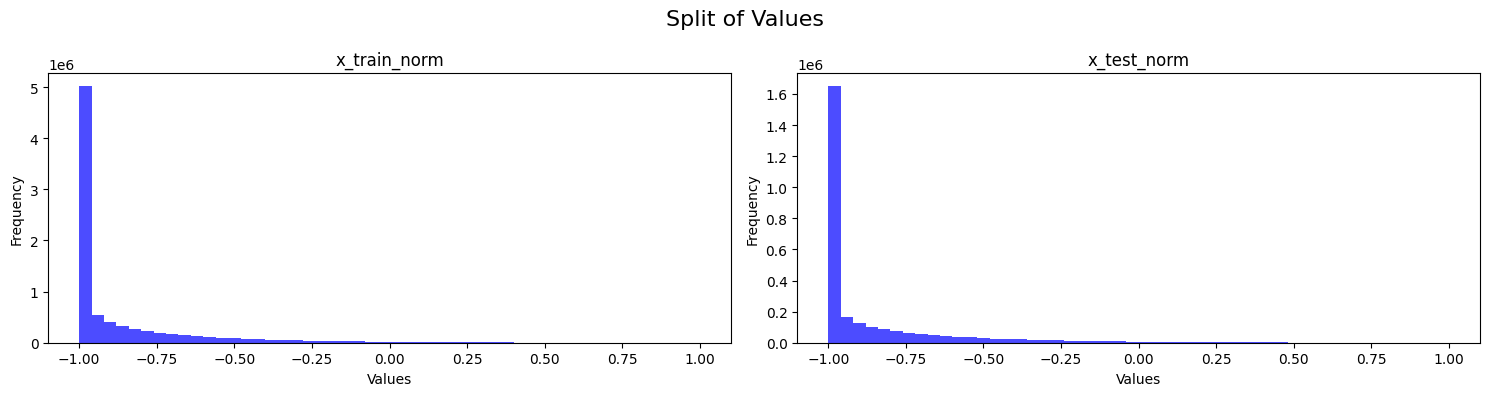

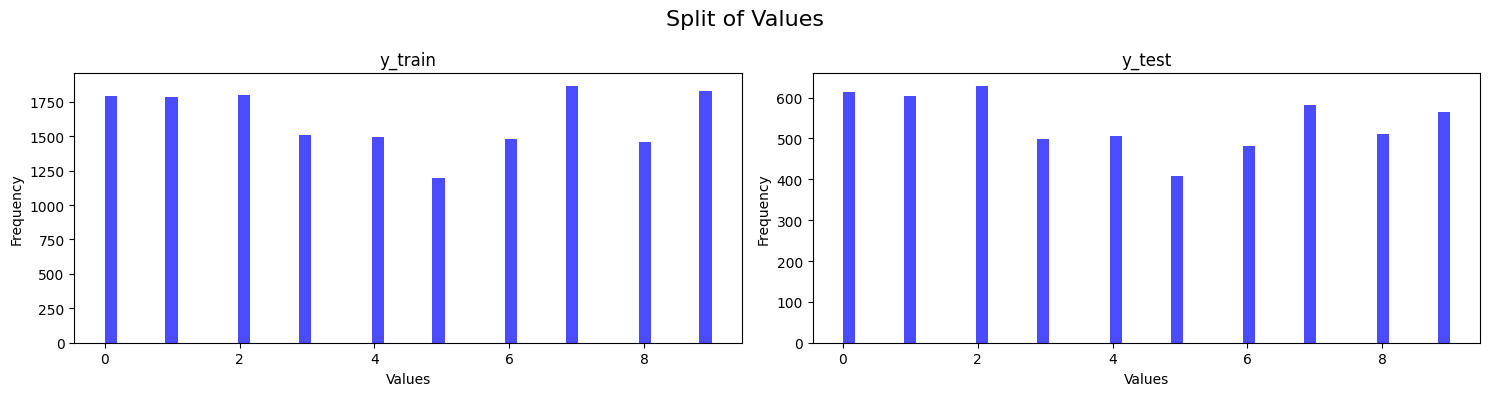

In [2]:
x_train_norm = load_model("datasets/saved_datasets/task1/x_train")
x_test_norm = load_model("datasets/saved_datasets/task1/x_test")
y_train = load_model("datasets/saved_datasets/task1/y_train")
y_test = load_model("datasets/saved_datasets/task1/y_test")

plot_class_split_of_values([x_train_norm, x_test_norm], ["x_train_norm", "x_test_norm"])
plot_class_split_of_values([y_train, y_test], ["y_train", "y_test"])

---
## MLP Classifier Training

The model was trained with an MLP classifier, with the results being validated using Holdout, Cross Validation, K-fold Cross Validation, and Stratified K-fold Cross Validation.

The best accuracy received for training and testing before hyperparameter optimisation is `0.973` and `0.928`. This base model served as the starting benchmark for evaluation.

In [3]:
warnings.filterwarnings("ignore", category=ConvergenceWarning)
mlp_training_results = mlp_classifier(x_train_norm, x_test_norm, y_train, y_test)
save_model(mlp_training_results, "models/task2/mlp_results")

------ Holdout Validation ------
Training Accuracy: 0.9706172839506173
Testing Accuracy: 0.9288888888888889
------ Cross Validation ------
Mean Accuracy: 0.9253086419753085
------ K fold Validation ------
Mean Accuracy: 0.9276543209876543
Std Deviation: 0.008940181229744031
------ Stratified K fold Validation ------
Mean Accuracy: 0.9248765432098764
Std Deviation: 0.005810671900982063
models/task2/mlp_results has the new model!


In [4]:
mlp_training_results = load_model("models/task2/mlp_results")

----
## Hyperparameter Optimisation

Best configuration - hidden_layers=(100,), activation=tanh, solver=adam, alpha=0.05

Mean - 0.932037037037037

<b style="color: orange;">SAVE MODEL</b> 

In [ ]:
parameters = {
    "hidden_layers": [(50,50,50), (50,100,50), (100,)],
    "activations": ['tanh', 'relu'],
    "solvers": ['sgd', 'adam'],
    "alphas": [0.0001, 0.05]
}

best_config = find_best_configuration_mlp(parameters, x_train_norm, x_test_norm, y_train, y_test)
print(best_config)


# hidden_layers = [(50,50,50), (50,100,50), (100,)]
# activations = ['tanh', 'relu']
# solvers = ['sgd', 'adam']
# alphas = [0.0001, 0.05]
# outer_cv = KFold(n_splits=10, shuffle=True)

# for layer in range(len(hidden_layers)):
#      for activation in range(len(activations)):
#           for solver in range(len(solvers)):
#                for alpha in range(len(alphas)):
#                     inner_scores = []
#                     mlp_clf = MLPClassifier(hidden_layer_sizes=hidden_layers[layer], activation=activations[activation], solver=solvers[solver], alpha=alphas[alpha])

#                     # Nested CV
#                     for train_index, val_index in outer_cv.split(x_train_norm):
#                          X_train, X_val = x_train_norm[train_index], x_train_norm[val_index]
#                          Y_train, Y_val = y_train[train_index], y_train[val_index]
#                          mlp_clf.fit(X_train, Y_train)
#                          training_score = mlp_clf.score(X_train, Y_train)
#                          test_score = mlp_clf.score(X_val, Y_val)
#                          inner_scores.append(test_score)
                    
#                     mean_score = sum(inner_scores) / len(inner_scores)

#                     print(f"------- With hidden_layers={hidden_layers[layer]}, activation={activations[activation]}, solver={solvers[solver]}, alpha={alphas[alpha]}")
#                     holdout_validation(mlp_clf, x_train_norm, x_test_norm, y_train, y_test)
#                     print(f"Mean - {mean_score}")

------- With hidden_layers=(50, 50, 50), activation=tanh, solver=sgd, alpha=0.0001
------ Holdout Validation ------
Training Accuracy: 0.9637654320987654
Testing Accuracy: 0.9288888888888889
Mean - 0.9297530864197532
------- With hidden_layers=(50, 50, 50), activation=tanh, solver=sgd, alpha=0.05
------ Holdout Validation ------
Training Accuracy: 0.9629012345679012
Testing Accuracy: 0.9253703703703704
Mean - 0.928641975308642
------- With hidden_layers=(50, 50, 50), activation=tanh, solver=adam, alpha=0.0001
------ Holdout Validation ------
Training Accuracy: 0.981358024691358
Testing Accuracy: 0.9251851851851852
Mean - 0.9263580246913581
------- With hidden_layers=(50, 50, 50), activation=tanh, solver=adam, alpha=0.05
------ Holdout Validation ------
Training Accuracy: 0.9669135802469135
Testing Accuracy: 0.9151851851851852
Mean - 0.9264197530864198


/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/neural_network/_multilayer_perceptron.py:698: UserWarning: Training interrupted by user.
  warnings.warn("Training interrupted by user.")


-----------------------------------------------------------------
## Evaluation <b style="color: blue;">Define metric used for evaluation</b>

In [4]:
fetch_classification_report(mlp_training_results, x_test_norm, y_test)

----- Classification Report -----
              precision    recall  f1-score   support

         0.0       0.93      0.93      0.93       613
         1.0       0.98      0.96      0.97       605
         2.0       0.90      0.93      0.92       628
         3.0       0.83      0.86      0.84       499
         4.0       0.94      0.94      0.94       507
         5.0       0.91      0.93      0.92       409
         6.0       0.88      0.83      0.85       481
         7.0       0.95      0.97      0.96       583
         8.0       0.93      0.88      0.90       511
         9.0       0.98      0.98      0.98       564

    accuracy                           0.92      5400
   macro avg       0.92      0.92      0.92      5400
weighted avg       0.93      0.92      0.92      5400



The goal of the classification report is the difference in performance for each class. Overall, it can be seen that each class performs well in terms of precision and recall, except for classes `3.0` and `6.0`.

#### Confusion Matrix
Whilst the classification report is good at showing (i) the correctness of true positive classifications by the model and (ii) whether all the true positive instances were identified, a granular deep-dive needed to be done to identify where the model was performing poorly and this was possible through the confusion matrix.

The confusion matrix shed light on 4 metrics - `True Positive`, `True Negative`, `False Positive`, and `False Negative` for each class.

<b>This was needed specifically to evaluate where classes `3.0` and `6.0` were faulting.</b>

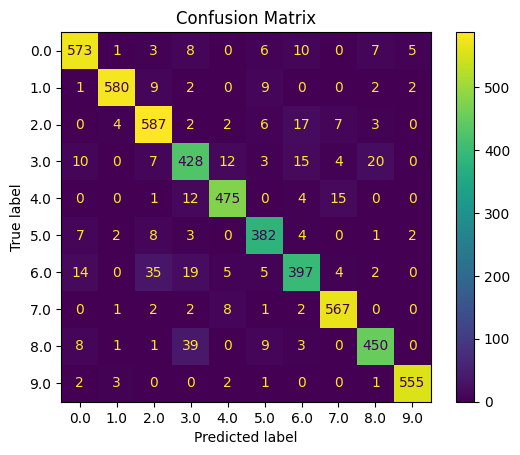

In [19]:
plot_confusion_matrix(mlp_training_results, x_test_norm, y_test, False)

From the confusion matrix and split of metrics, it can be observed that the `Class 3` has the highest <b>False Positive</b> value (84) meaning it is misclassyfing the wrong values as true higher than any other class. 

`Class 6` has the highest <b>False Negative</b> value (84) means it is misclassifying the most actually true values as false.

#### Precision Recall, ROC, and DET Curve

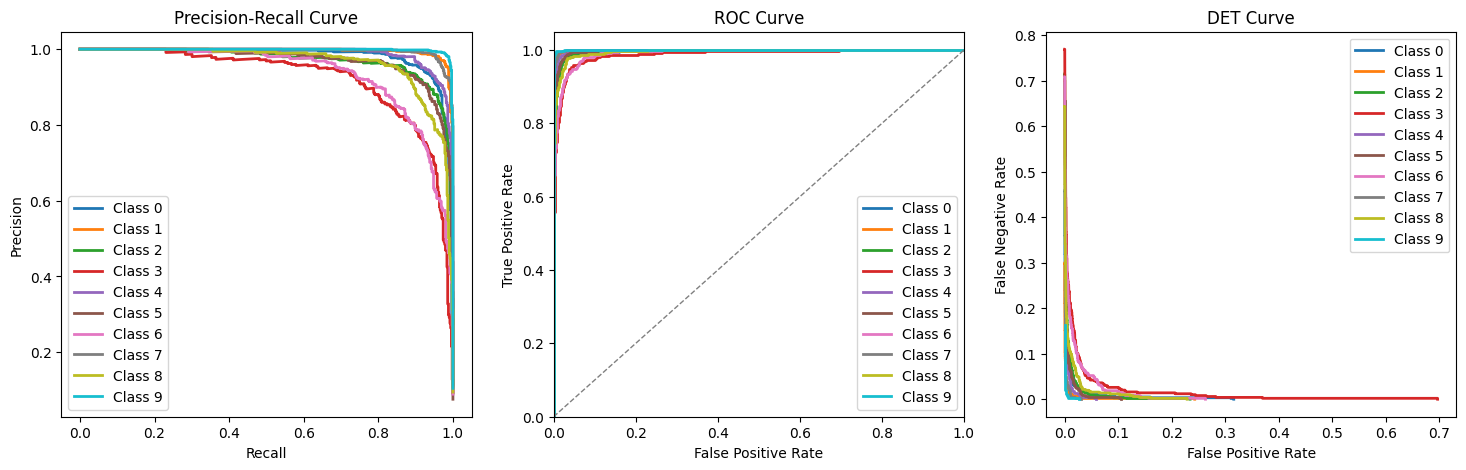

In [6]:
fig, axes = plt.subplots(1, 3, figsize=(18, 5))
y_pred_prob = mlp_training_results.predict_proba(x_test_norm)
y_pred = mlp_training_results.predict(x_test_norm)
plot_precision_recall_curve(y_test, y_pred_prob, axes[0])
plot_roc_curve(y_test, y_pred_prob, axes[1])
plot_det_curve(y_test, y_pred_prob, axes[2])

#### Predicted vs Actual Values

An excerpt from both the predictions and actuals dataset was taken to visualise the difference between the two and in the cases where there was a mismatch, how severe it was. 

<b>Note - In this case, only 100 samples were taken as taking all made the visual unclear</b>

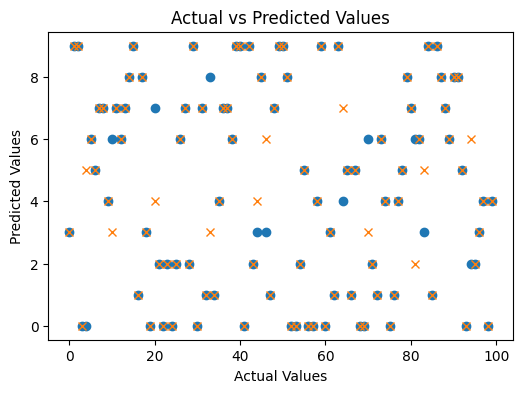

In [7]:
plot_predicted_vs_actual(y_test, y_pred)

In [8]:
fetch_accuracy_score(y_test, y_pred)
fetch_log_loss(y_test, y_pred_prob)

Accuracy: 0.9248148148148149
Log Loss: 0.2217282976089409


-----
## Improving Performance

Class 3 and 6 have low precision/recall comparatively to the other classes and there were a few hypothesis of the reason:

1. Imbalanced Dataset - To alleviate this, undersampling and oversampling was tried

2. Not having the right number of features?

#### Undersampling

In [9]:
# Trained undersampling because it had better performance in the classification report -> Not taken over original dataset because does not improve accuracy
x_balanced, y_balanced = dataset_undersampling(x_train_norm, y_train)
mlp_undersampling = mlp_classifier(x_balanced, x_test_norm, y_balanced, y_test)
save_model(mlp_undersampling, "models/task2/mlp_results_undersampled")

------ Holdout Validation ------
Training Accuracy: 0.28594142259414224
Testing Accuracy: 0.277037037037037
------ Cross Validation ------
Mean Accuracy: 0.33665271966527194
------ K fold Validation ------
Mean Accuracy: 0.9219246861924686
Std Deviation: 0.004538157945759413
------ Stratified K fold Validation ------
Mean Accuracy: 0.9238493723849371
Std Deviation: 0.007973977740298996
models/task2/mlp_results_undersampled has the new model!


In [4]:
x_balanced, y_balanced = dataset_undersampling(x_train_norm, y_train)
mlp_undersampling = load_model("models/task2/mlp_results_undersampled")

5.0

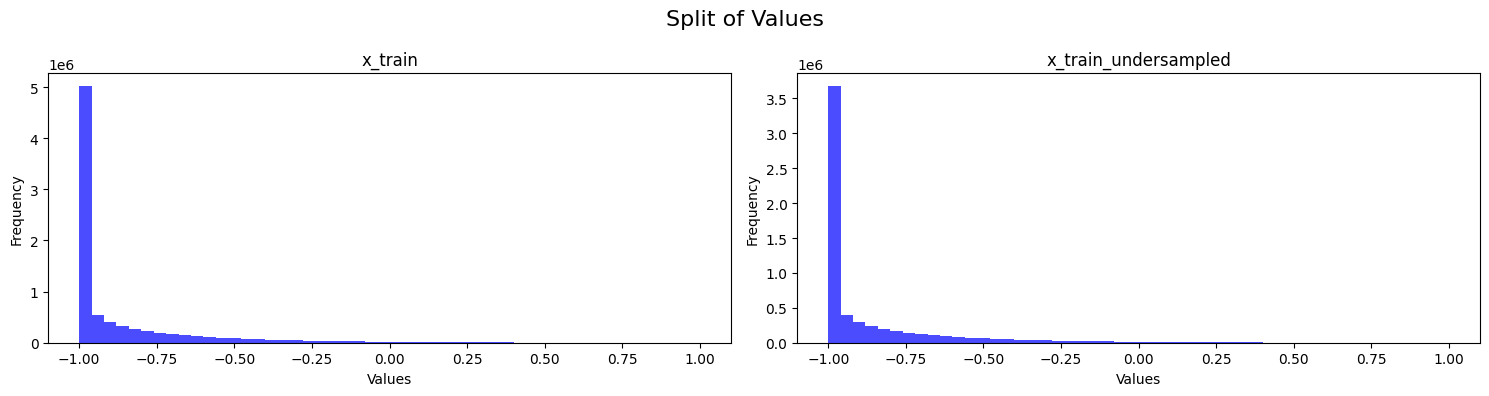

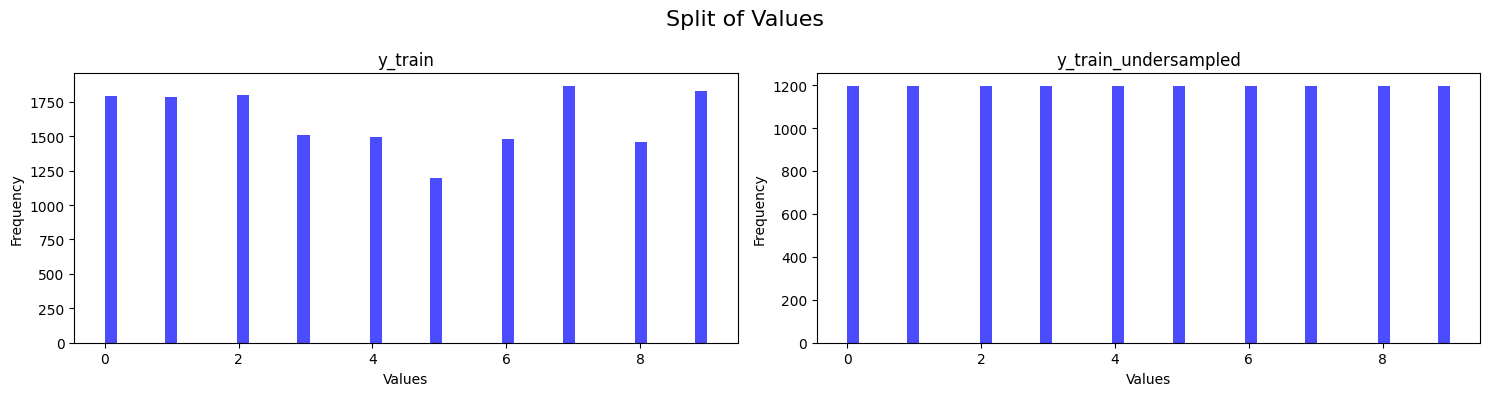

In [10]:
plot_class_split_of_values([x_train_norm, x_balanced], ["x_train", "x_train_undersampled"])
plot_class_split_of_values([y_train, y_balanced], ["y_train", "y_train_undersampled"])

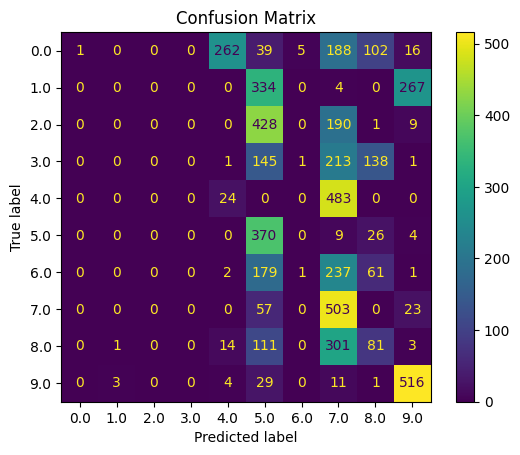

In [12]:
plot_confusion_matrix(mlp_undersampling, x_test_norm, y_test, False)

#### Oversampling

In [13]:
x_balanced_over, y_balanced_over = dataset_oversampling(x_train_norm, y_train)
mlp_oversampling = mlp_classifier(x_balanced_over, x_test_norm, y_balanced_over, y_test)
save_model(mlp_oversampling, "models/task2/mlp_results_oversampled")

------ Holdout Validation ------
Training Accuracy: 0.1
Testing Accuracy: 0.09462962962962963
------ Cross Validation ------
Mean Accuracy: 0.1670960815888352
------ K fold Validation ------
Mean Accuracy: 0.9556092324208267
Std Deviation: 0.008862536493279893
------ Stratified K fold Validation ------
Mean Accuracy: 0.9592055823939882
Std Deviation: 0.004038270074890832
models/task2/mlp_results_oversampled has the new model!


In [13]:
x_balanced_over, y_balanced_over = dataset_oversampling(x_train_norm, y_train)
mlp_oversampling = load_model("models/task2/mlp_results_oversampled")

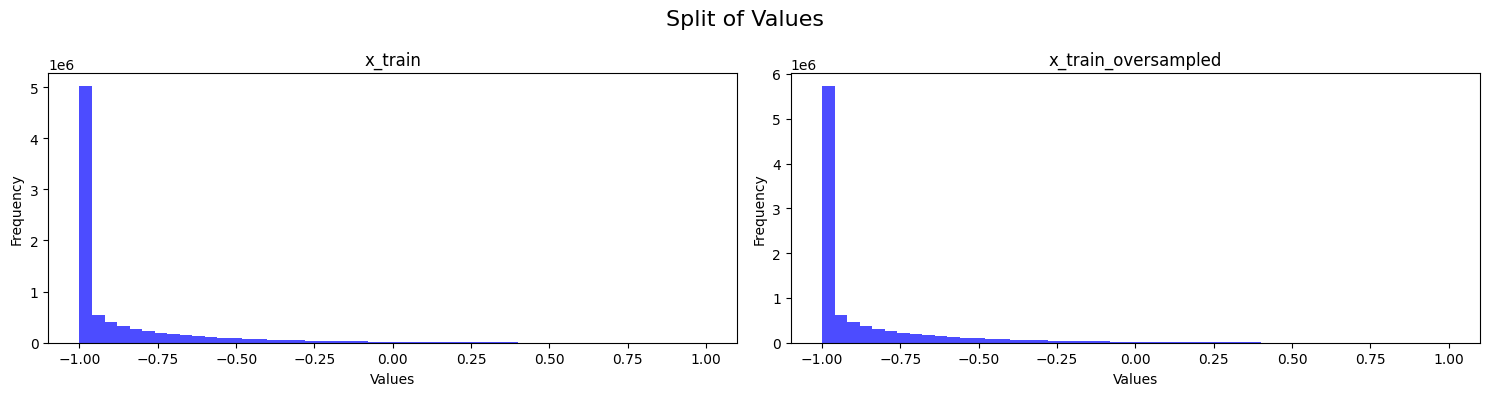

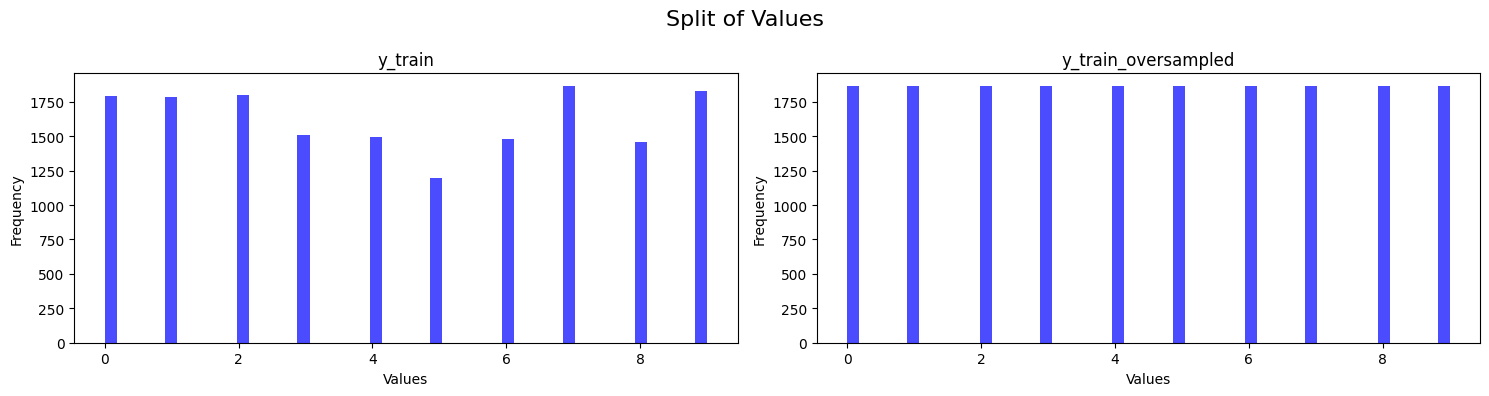

In [14]:
plot_class_split_of_values([x_train_norm, x_balanced_over], ["x_train", "x_train_oversampled"])
plot_class_split_of_values([y_train, y_balanced_over], ["y_train", "y_train_oversampled"])

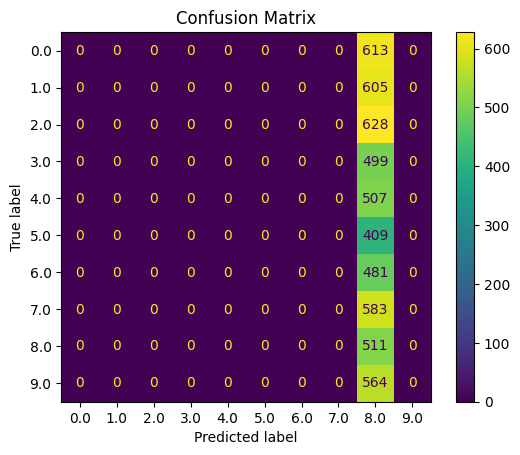

In [15]:
plot_confusion_matrix(mlp_oversampling, x_test_norm, y_test, False)

#### Classification Report Comparison

In [16]:
# Classification Reports Grouped
warnings.filterwarnings("ignore", category=UndefinedMetricWarning)
fetch_multiple_classification_report([mlp_training_results, mlp_undersampling, mlp_oversampling], ["Original Dataset", "Undersampling", "Oversampling"], x_test_norm, y_test)

----- Original Dataset -----
              precision    recall  f1-score   support

         0.0       0.93      0.93      0.93       613
         1.0       0.98      0.96      0.97       605
         2.0       0.90      0.93      0.92       628
         3.0       0.83      0.86      0.84       499
         4.0       0.94      0.94      0.94       507
         5.0       0.91      0.93      0.92       409
         6.0       0.88      0.83      0.85       481
         7.0       0.95      0.97      0.96       583
         8.0       0.93      0.88      0.90       511
         9.0       0.98      0.98      0.98       564

    accuracy                           0.92      5400
   macro avg       0.92      0.92      0.92      5400
weighted avg       0.93      0.92      0.92      5400

----- Undersampling -----
              precision    recall  f1-score   support

         0.0       1.00      0.00      0.00       613
         1.0       0.00      0.00      0.00       605
         2.0       0.00

As seen in the classification report, the original dataset without undersampling and oversampling performed best hence, was not chosen for further usage

----
As stated at the start, the 2 hypothesis to be validated to pinpoint the improvement in performance is whether it was (i) using the MLP Classifier or (ii) Use of all features or both.

>First - The comparison of the SVC with the top 10 selected features against MLP

In [17]:
x_train_selected, x_test_selected = calculate_variance_threshold(x_train_norm, x_test_norm, False) # Variance threshold to remove features
feature_correlation = pearson_correlation(x_train_selected, y_train)
top_features_indices = feature_correlation[:10]

In [20]:
mlp_10_features = mlp_classifier(x_train_selected[:, top_features_indices], x_test_selected[:, top_features_indices], y_train, y_test)
svc_10_features = svc_classifier(x_train_selected[:, top_features_indices], x_test_selected[:, top_features_indices], y_train, y_test)
save_model(mlp_10_features, "models/task2/mlp_results_10_features")
save_model(svc_10_features, "models/task2/svc_results_10_features")

/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


------ Holdout Validation ------
Training Accuracy: 0.5199382716049382
Testing Accuracy: 0.5031481481481481


/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iteration

------ Cross Validation ------
Mean Accuracy: 0.510493827160494


/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iteration

------ K fold Validation ------
Mean Accuracy: 0.5151234567901234
Std Deviation: 0.018547816330404737


/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iteration

------ Stratified K fold Validation ------
Mean Accuracy: 0.5127160493827161
Std Deviation: 0.0105957289091977
------ Holdout Validation ------
Training Accuracy: 0.610246913580247
Testing Accuracy: 0.567037037037037
------ Cross Validation ------
Mean Accuracy: 0.5775308641975309
------ K fold Validation ------
Mean Accuracy: 0.5793055555555556
Std Deviation: 0.01615276384509446
------ Stratified K fold Validation ------
Mean Accuracy: 0.5782407407407406
Std Deviation: 0.011533261376116538
models/task2/mlp_results_10_features has the new model!
models/task2/svc_results_10_features has the new model!


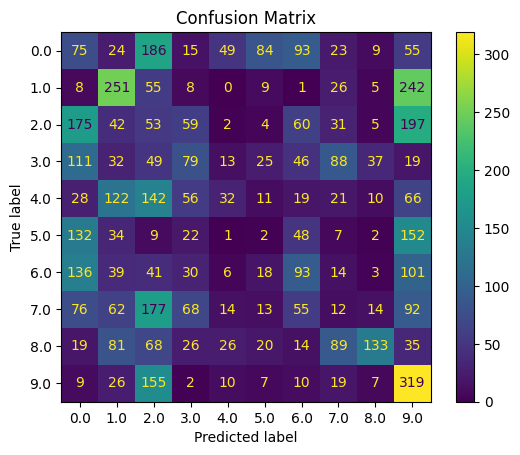

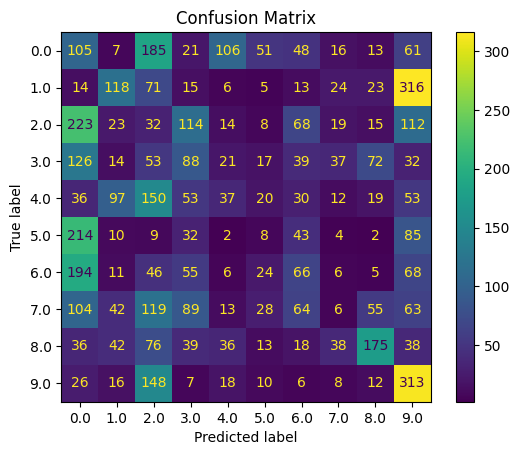

In [18]:
mlp_10_features = load_model("models/task2/mlp_results_10_features")
svc_10_features = load_model("models/task2/svc_results_10_features")
y_pred_svc = mlp_10_features.predict(x_test_norm[:, top_features_indices])
y_pred_mlp = svc_10_features.predict(x_test_norm[:, top_features_indices])
# plot_predicted_vs_actual(y_test, y_pred_svc)
# plot_predicted_vs_actual(y_test, y_pred_mlp)
plot_confusion_matrix(mlp_10_features, x_test_norm[:, top_features_indices], y_test, False)
plot_confusion_matrix(svc_10_features, x_test_norm[:, top_features_indices], y_test, False)

<b>Conclusion - less accuracy with MLP trained model with the top 10 features</b>

>Second - The comparison of SVC and MLP with all features

In [35]:
svc_classifier(x_train_norm, x_test_norm, y_train, y_test)

------ Holdout Validation ------
Training Accuracy: 0.9761728395061728
Testing Accuracy: 0.9305555555555556
------ Cross Validation ------
Mean Accuracy: 0.9348765432098766
------ K fold Validation ------
Mean Accuracy: 0.9393518518518519
Std Deviation: 0.005512953943186738
------ Stratified K fold Validation ------
Mean Accuracy: 0.9388888888888889
Std Deviation: 0.0045124047892634135


SVC(C=1, probability=True)

In [36]:
mlp_classifier(x_train_norm, x_test_norm, y_train, y_test)
# Logistic regression

------ Holdout Validation ------
Training Accuracy: 0.9640123456790124
Testing Accuracy: 0.9248148148148149
------ Cross Validation ------
Mean Accuracy: 0.9309876543209876
------ K fold Validation ------
Mean Accuracy: 0.9270987654320987
Std Deviation: 0.005204622592155881
------ Stratified K fold Validation ------
Mean Accuracy: 0.9253086419753085
Std Deviation: 0.0069344921827079594


MLPClassifier(activation='tanh', hidden_layer_sizes=(50, 100, 50),
              random_state=42, shuffle=False, solver='sgd')

<b style="color: aqua">Conclusion - After evaluating both hypothesis, it can be seen that whilst using MLP actually decreases the accuracy of the model, adding more features significantly improves the performance.</b>